In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from mpl_toolkits import mplot3d
from scipy.spatial import distance
from scipy.signal import savgol_filter
from statistics import mean, stdev
from scipy import linalg, interp
from sklearn import svm, datasets, preprocessing
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA as sklearnPCA
from scipy.fftpack import fft, dct
from itertools import cycle
import itertools
import warnings
warnings.filterwarnings('ignore')

#Consts

joint_num = 60
data_dir_path = 'C://Users//user//Documents//Datasets//ParkinsonsDetectionDataset//'
project_dir_path = 'C://development//ParkinsonsKinectApplication//ParkinsonsKinectApplication//'
train_dir_path = 'C://development//ParkinsonsKinectApplication//ParkinsonsKinectApplication//TrainingData//'
pd_on = 'PD_ON//'
pd_off = 'PD_OFF//'
control = 'CONTROL//'

label_map = {'NONE':0,
           'REGULAR':1,
           'SEVERE':2}
label_names = ['NONE', 'REGULAR', 'SEVERE']

epsilon, kappa, heta = 0.3, 10, 10
w, h = 19, 3;

In [2]:
def distance2D(x1, y1, x2, y2):
    return np.sqrt(np.square(x2 - x1) + np.square(y2 - y1))

def scaling(x1, y1, x2, y2):
    return distance2D(x1, y1, x2, y2)/100

In [3]:
def cleanFile(fname):
    idx = []

    df_joint_data = pd.read_csv(fname, skipinitialspace=True).drop_duplicates().reset_index(drop=True)[:-5]

    if 'drop_this_col' in df_joint_data.columns:
        del df_joint_data['drop_this_col']

    for i in range(len(df_joint_data.index)):
        idx.append(i*0.033) #Could make this stochastic

    df_index = pd.DataFrame({'time': idx})
    df_joints = df_index.join(df_joint_data)

    df_joints.set_index('time', inplace=True)

    if (len(df_joints.columns)) > joint_num:
        df_joints.drop(df_joints.iloc[:, 60:1892], inplace=True, axis=1)

    if 'ShoulderLeftX Position' in df_joints.columns:    
        df_joints = df_joints.rename(columns={'ShoulderLeftX Position': 'ShoulderLeftXPosition'})

    return df_joints 

In [4]:
def normalization(df_joints):
    for i, row in df_joints.iterrows():
        scaling_factor = scaling(row.SpineXPosition, row.SpineYPosition, row.ShoulderCenterXPosition, row.ShoulderCenterYPosition)/100
        
        df_joints.set_value(i, 'SpineXPosition', (row.SpineXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'SpineYPosition', (row.SpineYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'SpineZPosition', (row.SpineZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'ShoulderCenterXPosition', (row.ShoulderCenterXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'ShoulderCenterYPosition', (row.ShoulderCenterYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'ShoulderCenterZPosition', (row.ShoulderCenterZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'HeadXPosition', (row.HeadXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'HeadYPosition', (row.HeadYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'HeadZPosition', (row.HeadZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'ShoulderLeftXPosition', (row.ShoulderLeftXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'ShoulderLeftYPosition', (row.ShoulderLeftYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'ShoulderLeftZPosition', (row.ShoulderLeftZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'ElbowLeftXPosition', (row.ElbowLeftXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'ElbowLeftYPosition', (row.ElbowLeftYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'ElbowLeftZPosition', (row.ElbowLeftZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'WristLeftXPosition', (row.WristLeftXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'WristLeftYPosition', (row.WristLeftYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'WristLeftZPosition', (row.WristLeftZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'HandLeftXPosition', (row.HandLeftXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'HandLeftYPosition', (row.HandLeftYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'HandLeftZPosition', (row.HandLeftZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'ShoulderRightXPosition', (row.ShoulderRightXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'ShoulderRightYPosition', (row.ShoulderRightYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'ShoulderRightZPosition', (row.ShoulderRightZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'ElbowRightXPosition', (row.ElbowRightXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'ElbowRightYPosition', (row.ElbowRightYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'ElbowRightZPosition', (row.ElbowRightZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'WristRightXPosition', (row.WristRightXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'WristRightYPosition', (row.WristRightYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'WristRightZPosition', (row.WristRightZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'HandRightXPosition', (row.HandRightXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'HandRightYPosition', (row.HandRightYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'HandRightZPosition', (row.HandRightZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'HipLeftXPosition', (row.HipLeftXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'HipLeftYPosition', (row.HipLeftYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'HipLeftZPosition', (row.HipLeftZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'KneeLeftXPosition', (row.KneeLeftXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'KneeLeftYPosition', (row.KneeLeftYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'KneeLeftZPosition', (row.KneeLeftZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'AnkleLeftXPosition', (row.AnkleLeftXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'AnkleLeftYPosition', (row.AnkleLeftYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'AnkleLeftZPosition', (row.AnkleLeftZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'FootLeftXPosition', (row.FootLeftXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'FootLeftYPosition', (row.FootLeftYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'FootLeftZPosition', (row.FootLeftZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'HandRightXPosition', (row.HandRightXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'HandRightYPosition', (row.HandRightYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'HandRightZPosition', (row.HandRightZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'KneeRightXPosition', (row.KneeRightXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'KneeRightYPosition', (row.KneeRightYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'KneeRightZPosition', (row.KneeRightZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'AnkleRightXPosition', (row.AnkleRightXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'AnkleRightYPosition', (row.AnkleRightYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'AnkleRightZPosition', (row.AnkleRightZPosition - row.HipCenterZPosition))
        
        df_joints.set_value(i, 'FootRightXPosition', (row.FootRightXPosition - row.HipCenterXPosition)/scaling_factor)
        df_joints.set_value(i, 'FootRightYPosition', (row.FootRightYPosition - row.HipCenterYPosition)/scaling_factor)
        df_joints.set_value(i, 'FootRightZPosition', (row.FootRightZPosition - row.HipCenterZPosition))

In [5]:
def savGolFilter(df_joints):
    for col in df_joints.columns:
        smoothed = savgol_filter(df_joints[col], 5, 2, mode='nearest') #Check correctness of paramters
        df_joints[col] = smoothed
        
def dctFilter(df_joints):
    return dct((fft(df_joints).real), 1)

In [6]:
def descriptor(df_joints, w, h, type):
    descriptor_list = []

    descriptor = [[0 for x in range(w)] for y in range(h)] 

    for i, row in df_joints.iterrows():

        descriptor[0][0] = row.SpineXPosition 
        descriptor[0][1] = row.ShoulderCenterXPosition 
        descriptor[0][2] = row.HeadXPosition 
        descriptor[0][3] = row.ShoulderLeftXPosition 
        descriptor[0][4] = row.ElbowLeftXPosition 
        descriptor[0][5] = row.WristLeftXPosition 
        descriptor[0][6] = row.HandLeftXPosition 
        descriptor[0][7] = row.ShoulderRightXPosition 
        descriptor[0][8] = row.ElbowRightXPosition 
        descriptor[0][9] = row.WristRightXPosition 
        descriptor[0][10] = row.HandRightXPosition
        descriptor[0][11] = row.HipLeftXPosition
        descriptor[0][12] = row.KneeLeftXPosition
        descriptor[0][13] = row.AnkleLeftXPosition
        descriptor[0][14] = row.FootLeftXPosition
        descriptor[0][15] = row.HandRightXPosition
        descriptor[0][16] = row.KneeRightXPosition
        descriptor[0][17] = row.AnkleRightXPosition
        descriptor[0][18] = row.FootRightXPosition

        descriptor[1][0] = row.SpineYPosition 
        descriptor[1][1] = row.ShoulderCenterYPosition 
        descriptor[1][2] = row.HeadYPosition 
        descriptor[1][3] = row.ShoulderLeftYPosition 
        descriptor[1][4] = row.ElbowLeftYPosition 
        descriptor[1][5] = row.WristLeftYPosition 
        descriptor[1][6] = row.HandLeftYPosition 
        descriptor[1][7] = row.ShoulderRightYPosition 
        descriptor[1][8] = row.ElbowRightYPosition 
        descriptor[1][9] = row.WristRightYPosition 
        descriptor[1][10] = row.HandRightYPosition
        descriptor[1][11] = row.HipLeftYPosition
        descriptor[1][12] = row.KneeLeftYPosition
        descriptor[1][13] = row.AnkleLeftYPosition
        descriptor[1][14] = row.FootLeftYPosition
        descriptor[1][15] = row.HandRightYPosition
        descriptor[1][16] = row.KneeRightYPosition
        descriptor[1][17] = row.AnkleRightYPosition
        descriptor[1][18] = row.FootRightYPosition

        descriptor[2][0] = row.SpineZPosition 
        descriptor[2][1] = row.ShoulderCenterZPosition 
        descriptor[2][2] = row.HeadZPosition 
        descriptor[2][3] = row.ShoulderLeftZPosition 
        descriptor[2][4] = row.ElbowLeftZPosition 
        descriptor[2][5] = row.WristLeftZPosition 
        descriptor[2][6] = row.HandLeftZPosition 
        descriptor[2][7] = row.ShoulderRightZPosition 
        descriptor[2][8] = row.ElbowRightZPosition 
        descriptor[2][9] = row.WristRightZPosition 
        descriptor[2][10] = row.HandRightZPosition
        descriptor[2][11] = row.HipLeftZPosition
        descriptor[2][12] = row.KneeLeftZPosition
        descriptor[2][13] = row.AnkleLeftZPosition
        descriptor[2][14] = row.FootLeftZPosition
        descriptor[2][15] = row.HandRightZPosition
        descriptor[2][16] = row.KneeRightZPosition
        descriptor[2][17] = row.AnkleRightZPosition
        descriptor[2][18] = row.FootRightZPosition

        if type is 'position':
            df_points = pd.DataFrame(descriptor)
            descriptor_list.append(np.array(df_points.cov()))
        if type is 'velocity':
            df_speeds = pd.DataFrame(descriptor)
            descriptor_list.append(np.array(df_speeds.cov()))
        if type is 'acceleration':
            df_accs = pd.DataFrame(descriptor)
            descriptor_list.append(np.array(df_accs.cov()))
    return descriptor_list

In [7]:
def dissimilarity(covA, covB):    
    eigenvalues = linalg.eigvals(covA, covB)
    for i in range(eigenvalues.size):
        sigma += np.log(eigenvalues[i])**2
    return np.sqrt(sigma)

def reduce(covA):
    sklearn_pca = sklearnPCA(n_components=3)
    return sklearn_pca.fit_transform(covA)
    

In [8]:
def writeResults(fname, cov, label):
    output = ""

    for x in range(19):
        for y in range(3):
            output += str(cov[x][y]) + ","
    output += label + '\n'
    with open(fname, 'a+') as f:
        f.write(output)
        f.close()
        
def process(dataFname, trainFname_p, trainFname_s, trainFname_a, label):
    #Read file, clean and normalise
    df_joints = cleanFile(dataFname)
    normalization(df_joints)
    savGolFilter(df_joints)
        
    pos_list = []
    vel_list = []
    acc_list = []

    pos_list = descriptor(df_joints, w, h, type = 'position')
    vel_list = descriptor(df_joints.diff().dropna(), w, h, type = 'velocity')
    acc_list= descriptor(df_joints.diff().diff().dropna(), w, h, type = 'acceleration')

    P = np.array(pos_list)
    S = np.array(vel_list)
    A = np.array(acc_list)
        
    #Average Covariance Matrices Calculation
    cov_p = reduce(np.mean(P, axis=0))
    cov_g = reduce(np.mean(S, axis=0))
    cov_a = reduce(np.mean(A, axis=0))

    writeResults(trainFname_p, cov_p, label)
    writeResults(trainFname_s, cov_g, label)
    writeResults(trainFname_a, cov_g, label)   

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
def autoProcess(filelist, dir):
    for i in filelist:
        path = data_dir_path + dir + i
        print(path)
        if dir is control: 
            label = 'NONE'
        if dir is pd_on: 
            label = 'REGULAR'
        if dir is pd_off: 
            label = 'SEVERE'
        with open(path, 'r') as f:
            if 'front' in f.name:
                process(f, project_dir_path + "TrainingData" + "//train_position_front.csv", 
                        project_dir_path + "TrainingData" + "//train_velocity_front.csv", 
                        project_dir_path + "TrainingData" + "//train_acc_front.csv",label)
            if 'back' in f.name:
                process(f, project_dir_path + "TrainingData" + "//train_position_back.csv", 
                        project_dir_path + "TrainingData" + "//train_velocity_back.csv",
                        project_dir_path + "TrainingData" + "//train_acc_back.csv", label)
            if 'left' in f.name or 'LHS' in f.name:
                process(f, project_dir_path + "TrainingData" + "//train_position_left.csv", 
                        project_dir_path + "TrainingData" + "//train_velocity_left.csv",
                        project_dir_path + "TrainingData" + "//train_acc_left.csv", label)
            if 'right' in f.name or 'RHS' in f.name:
                process(f, project_dir_path + "TrainingData" + "//train_position_right.csv", 
                        project_dir_path + "TrainingData" + "//train_velocity_right.csv",
                        project_dir_path + "TrainingData" + "//train_acc_right.csv", label)
                
def autoCleanDir(filelist):
    for i in filelist:
        path = train_dir_path + i
        os.unlink(path)

autoCleanDir(os.listdir(train_dir_path))
                
autoProcess(os.listdir(data_dir_path + control), control)
autoProcess(os.listdir(data_dir_path + pd_on), pd_on)
autoProcess(os.listdir(data_dir_path + pd_off), pd_off)

C://Users//user//Documents//Datasets//ParkinsonsDetectionDataset//CONTROL//ID001-backv-636745912394485764.csv
C://Users//user//Documents//Datasets//ParkinsonsDetectionDataset//CONTROL//ID001-frontv-636745912297868841.csv
C://Users//user//Documents//Datasets//ParkinsonsDetectionDataset//CONTROL//ID001-leftv-636745912601359504.csv
C://Users//user//Documents//Datasets//ParkinsonsDetectionDataset//CONTROL//ID001-rightv-636745912517452301.csv
C://Users//user//Documents//Datasets//ParkinsonsDetectionDataset//CONTROL//ID002-backv-636745916414332215.csv
C://Users//user//Documents//Datasets//ParkinsonsDetectionDataset//CONTROL//ID002-frontv-636745915985521368.csv
C://Users//user//Documents//Datasets//ParkinsonsDetectionDataset//CONTROL//ID002-leftv-636745916565443317.csv
C://Users//user//Documents//Datasets//ParkinsonsDetectionDataset//CONTROL//ID002-rightv-636745916491776135.csv
C://Users//user//Documents//Datasets//ParkinsonsDetectionDataset//CONTROL//ID003-backv-636745917769603322.csv
C://Us

In [11]:
def classify(filename, y_l, sequence = "FRONT VIEW - POSITIONAL"):
    print("*********** CLASSIFICATION RESULTS FOR " + sequence + " ***********")
    classification_data = pd.read_csv(filename, names=["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14",
                                                       "15","16","17","18","19","20","21","22","23","24","25","26","27",
                                                       "28","29","30","31","32","33","34","35","36","37","38","39","40",
                                                       "41","42","43","44","45","46","47","48","49","50","51","52","53",
                                                       "54","55","56","label"])
    class_nums = np.array(classification_data['label'])
    classification_data["logical_label"] = classification_data["label"].dropna().apply(lambda x: label_map[x])
    del classification_data['label']
    
    X = np.array(classification_data)
    X_scaled = preprocessing.scale(X)
    
    y = label_binarize(y_l, classes=[0,1,2])
    n_classes = y.shape[1]
    means = X.mean(axis=0)
    stdevs = X.std(axis=0)
    np.transpose(X)

    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=6, test_size=.5)
    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(svm.SVC(kernel='linear'))
    y_score = classifier.fit(X_train, y_train).decision_function(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()


    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_score.argmax(axis=1))
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=label_names,
                          title='Confusion matrix, without normalization')

    plt.show()    

    fpr_items = list(fpr.items())
    tpr_items = list(tpr.items())

    from scipy.optimize import brentq
    from scipy.interpolate import interp1d
    eer = brentq(lambda x : 1. - x - interp1d(fpr_items[-1][1], tpr_items[-1][1])(x), 0., 1.)
    print('Equal Error Rate: ' + str(round(eer*100, 2)) + '%')

    acc_score = accuracy_score(y_test.argmax(axis=1), y_score.argmax(axis=1))
    print('Accuracy Score: ' + str(acc_score*100) + '%')
    prec = precision_score(y_test.argmax(axis=1), y_score.argmax(axis=1), average='macro')
    print('Precision Score: ' + str(prec*100) + '%')
    recall = recall_score(y_test.argmax(axis=1), y_score.argmax(axis=1), average='macro')
    print('Recall Score: ' + str(recall*100) + '%')
    print("\n\n")

C://development//ParkinsonsKinectApplication//ParkinsonsKinectApplication//TrainingData//train_acc_back.csv
*********** CLASSIFICATION RESULTS FOR BACK VIEW - ACCELERATION ***********


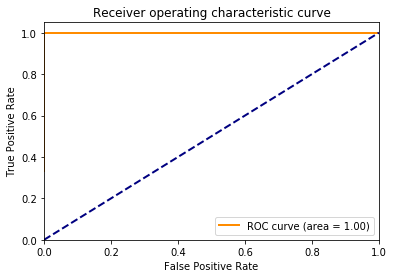

Confusion matrix, without normalization


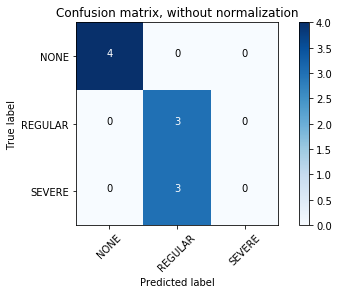

Equal Error Rate: 15.0%
Accuracy Score: 70.0%
Precision Score: 50.0%
Recall Score: 66.66666666666666%



C://development//ParkinsonsKinectApplication//ParkinsonsKinectApplication//TrainingData//train_acc_front.csv
*********** CLASSIFICATION RESULTS FOR FRONT VIEW - ACCELERATION ***********


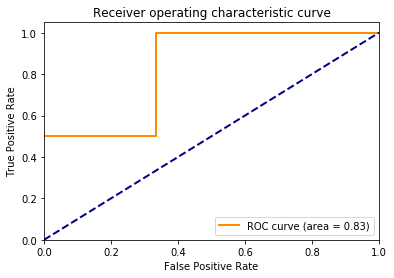

Confusion matrix, without normalization


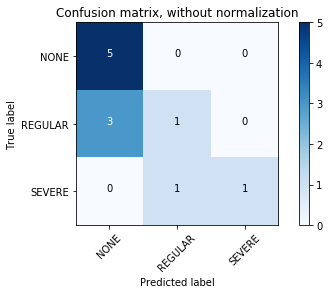

Equal Error Rate: 36.36%
Accuracy Score: 63.63636363636363%
Precision Score: 70.83333333333334%
Recall Score: 58.333333333333336%



C://development//ParkinsonsKinectApplication//ParkinsonsKinectApplication//TrainingData//train_acc_left.csv
*********** CLASSIFICATION RESULTS FOR LEFT VIEW - ACCELERATION ***********


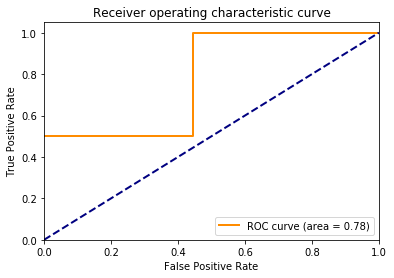

Confusion matrix, without normalization


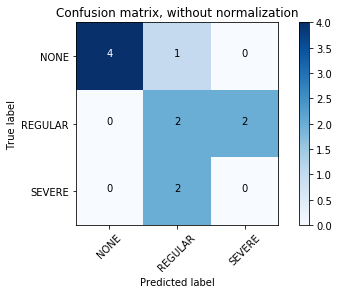

Equal Error Rate: 27.27%
Accuracy Score: 54.54545454545454%
Precision Score: 46.666666666666664%
Recall Score: 43.333333333333336%



C://development//ParkinsonsKinectApplication//ParkinsonsKinectApplication//TrainingData//train_acc_right.csv
*********** CLASSIFICATION RESULTS FOR RIGHT VIEW - ACCELERATION ***********


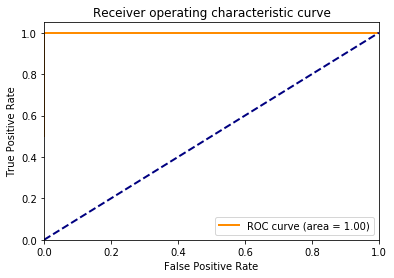

Confusion matrix, without normalization


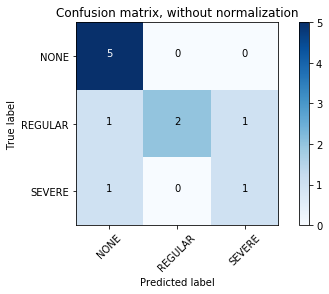

Equal Error Rate: 18.18%
Accuracy Score: 72.72727272727273%
Precision Score: 73.80952380952381%
Recall Score: 66.66666666666666%



C://development//ParkinsonsKinectApplication//ParkinsonsKinectApplication//TrainingData//train_position_back.csv
*********** CLASSIFICATION RESULTS FOR BACK VIEW - POSITIONAL ***********


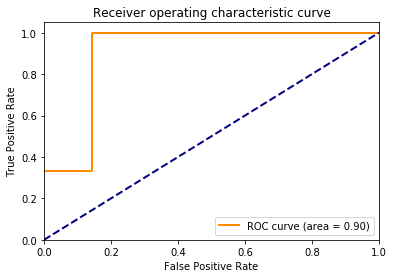

Confusion matrix, without normalization


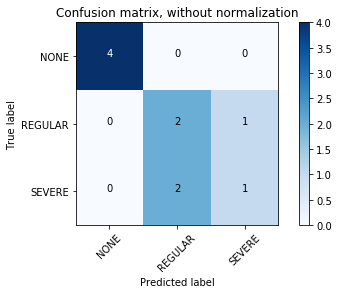

Equal Error Rate: 15.0%
Accuracy Score: 70.0%
Precision Score: 66.66666666666666%
Recall Score: 66.66666666666666%



C://development//ParkinsonsKinectApplication//ParkinsonsKinectApplication//TrainingData//train_position_front.csv
*********** CLASSIFICATION RESULTS FOR FRONT VIEW - POSITIONAL ***********


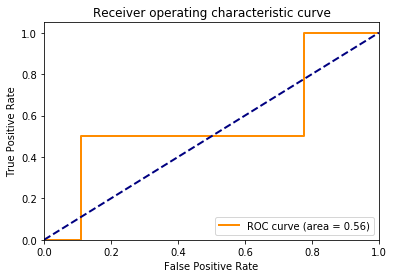

Confusion matrix, without normalization


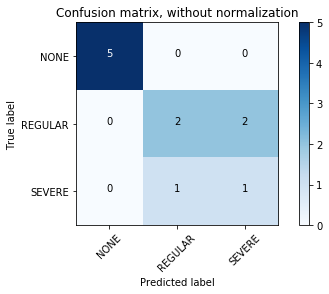

Equal Error Rate: 27.27%
Accuracy Score: 72.72727272727273%
Precision Score: 66.66666666666666%
Recall Score: 66.66666666666666%



C://development//ParkinsonsKinectApplication//ParkinsonsKinectApplication//TrainingData//train_position_left.csv
*********** CLASSIFICATION RESULTS FOR LEFT VIEW - POSITIONAL ***********


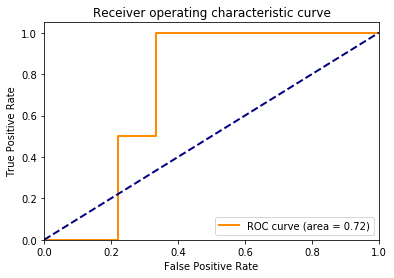

Confusion matrix, without normalization


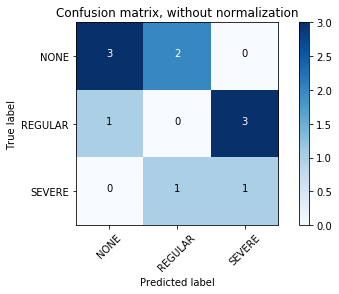

Equal Error Rate: 49.09%
Accuracy Score: 36.36363636363637%
Precision Score: 33.33333333333333%
Recall Score: 36.66666666666667%



C://development//ParkinsonsKinectApplication//ParkinsonsKinectApplication//TrainingData//train_position_right.csv
*********** CLASSIFICATION RESULTS FOR RIGHT VIEW - POSITIONAL ***********


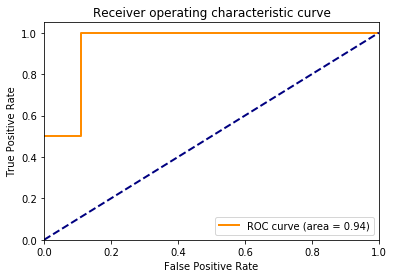

Confusion matrix, without normalization


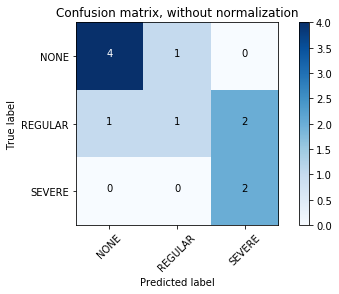

Equal Error Rate: 36.36%
Accuracy Score: 63.63636363636363%
Precision Score: 60.0%
Recall Score: 68.33333333333333%



C://development//ParkinsonsKinectApplication//ParkinsonsKinectApplication//TrainingData//train_velocity_back.csv
*********** CLASSIFICATION RESULTS FOR BACK VIEW - VELOCITY ***********


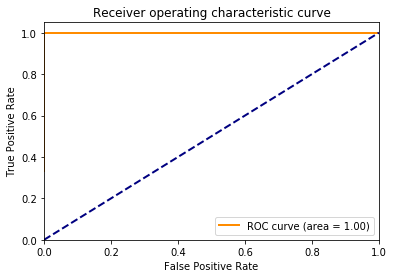

Confusion matrix, without normalization


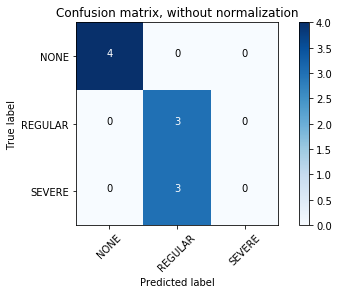

Equal Error Rate: 15.0%
Accuracy Score: 70.0%
Precision Score: 50.0%
Recall Score: 66.66666666666666%



C://development//ParkinsonsKinectApplication//ParkinsonsKinectApplication//TrainingData//train_velocity_front.csv
*********** CLASSIFICATION RESULTS FOR FRONT VIEW - VELOCITY ***********


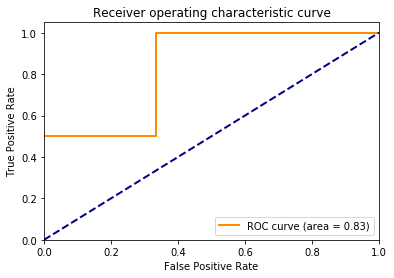

Confusion matrix, without normalization


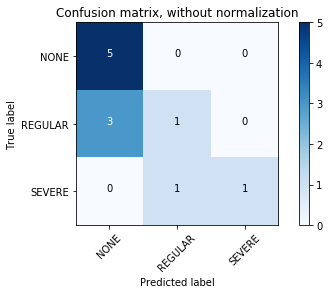

Equal Error Rate: 36.36%
Accuracy Score: 63.63636363636363%
Precision Score: 70.83333333333334%
Recall Score: 58.333333333333336%



C://development//ParkinsonsKinectApplication//ParkinsonsKinectApplication//TrainingData//train_velocity_left.csv
*********** CLASSIFICATION RESULTS FOR LEFT VIEW - VELOCITY ***********


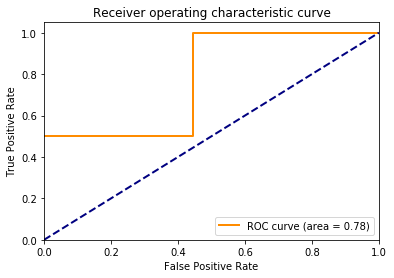

Confusion matrix, without normalization


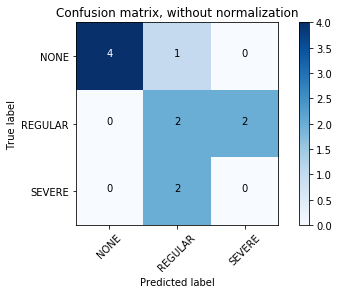

Equal Error Rate: 27.27%
Accuracy Score: 54.54545454545454%
Precision Score: 46.666666666666664%
Recall Score: 43.333333333333336%



C://development//ParkinsonsKinectApplication//ParkinsonsKinectApplication//TrainingData//train_velocity_right.csv
*********** CLASSIFICATION RESULTS FOR RIGHT VIEW - VELOCITY ***********


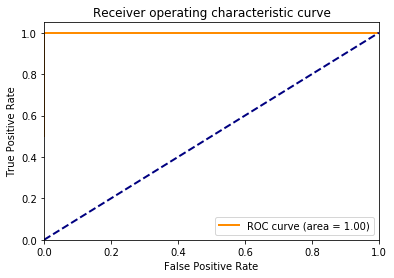

Confusion matrix, without normalization


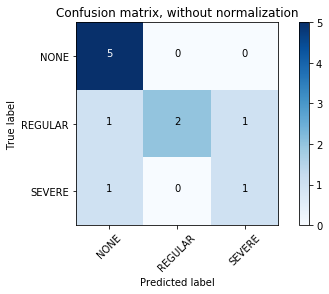

Equal Error Rate: 18.18%
Accuracy Score: 72.72727272727273%
Precision Score: 73.80952380952381%
Recall Score: 66.66666666666666%





In [12]:
def readInCovM(filename):
    w, h = 19, 3;
    label_list = []
    matrix = [0 for x in range(w*h)] 
    with open(filename) as fp:  
        line = fp.readline()
        while line:
            data = line.split(',')  
            label_list.append(label_map.get(data[w*h].strip()))
            line = fp.readline()
    return label_list

def autoDataLoader(filelist):
    for i in filelist:
        path = train_dir_path + i
        print(path)
        y = readInCovM(path)
        if 'front' in path and 'position' in path:
            classify(path, y)
        if 'back' in path and 'position' in path:
            classify(path, y, sequence = "BACK VIEW - POSITIONAL")
        if 'left' in path and 'position' in path:
            classify(path, y, sequence = "LEFT VIEW - POSITIONAL")
        if 'right' in path and 'position' in path:
            classify(path, y, sequence = "RIGHT VIEW - POSITIONAL") 
        if 'front' in path and 'velocity' in path:
            classify(path, y, sequence = "FRONT VIEW - VELOCITY")
        if 'back' in path and 'velocity' in path:
            classify(path, y, sequence = "BACK VIEW - VELOCITY")
        if 'left' in path and 'velocity' in path:
            classify(path, y, sequence = "LEFT VIEW - VELOCITY")
        if 'right' in path and 'velocity' in path:
            classify(path, y, sequence = "RIGHT VIEW - VELOCITY")
        if 'front' in path and 'acc' in path:
            classify(path, y, sequence = "FRONT VIEW - ACCELERATION")
        if 'back' in path and 'acc' in path:
            classify(path, y, sequence = "BACK VIEW - ACCELERATION")
        if 'left' in path and 'acc' in path:
            classify(path, y, sequence = "LEFT VIEW - ACCELERATION")
        if 'right' in path and 'acc' in path:
            classify(path, y, sequence = "RIGHT VIEW - ACCELERATION")
                
autoDataLoader(os.listdir(train_dir_path))